# Plot ELG chains
This jupyter notebook contains some code to make plots of the bestfits and contours for the abacus cubic ELG fits to both the mock mean and individual realisations.

In [10]:
# Import some necessary modules
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     

sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed

from barry.samplers import DynestySampler
from barry.samplers import NautilusSampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

#print(sys.path)
# Read in the fitter class to get all the info on the fit
#pfn = "../plots/desi_kp4_abacus_cubic_ELG/output/desi_kp4_abacus_cubic_ELG.fitter.pkl"

omega_matter_free = False

omega_matter_free_only = True

neff_free = False 

neff_free_only = False 

phase_shift_free = False #False 
wallisch18 = False 
eh1998 = False

CV = False  

pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG/output/desi_kp4_abacus_cubic_ELG.fitter.pkl"

if omega_matter_free: 
    pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_omfree/output/desi_kp4_abacus_cubic_ELG_omfree.fitter.pkl"

if neff_free: 
    pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_nefffree/output/desi_kp4_abacus_cubic_ELG_nefffree.fitter.pkl"
    
if phase_shift_free: 
    pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree.fitter.pkl"
    #pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-nosmoothFalse/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-nosmoothFalse.fitter.pkl"
    #pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-limitkmin/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-limitkmin.fitter.pkl"
    
    if wallisch18:
        pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-wallisch18/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-wallisch18.fitter.pkl"
    
    if eh1998:
        pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-eh1998/output/desi_kp4_abacus_cubic_ELG_phaseshiftfree-eh1998.fitter.pkl"
        
if neff_free_only:
    pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_nefffree-alphaeps_fixed/output/desi_kp4_abacus_cubic_ELG_nefffree-alphaeps_fixed.fitter.pkl"
    
if omega_matter_free_only:
    pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_omfree-alphaeps_fixed/output/desi_kp4_abacus_cubic_ELG_omfree-alphaeps_fixed.fitter.pkl"
    

with open(pfn, 'rb') as pickle_file:
    fitter = pickle.load(pickle_file)
    
    
nosigma_s_incorr = False
#print(dir(fitter.sampler))

# sigma_s_mean = 0
count = 0
beta_mean = 0


This code segment reads in the chains, plots the bestfit model vs. data and prepares stuff for contour plots and summary files

DESI KP4 Abacus CubicBox Pk ELG Prerecon mock mean 2 mean
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.79691877e+00  4.02217635e+05  8.55416453e+03 -8.66096094e+04
 -7.21926096e+04 -3.73731850e+04 -2.25044183e+04 -1.55592803e+04
 -1.12477967e+04 -9.17076605e+03 -7.28880229e+03  2.29800805e+05
  5.74051825e+03 -1.23054462e+05 -8.82277305e+04 -3.15879386e+04
 -4.25540379e+03  7.66562615e+03  1.12935615e+04  1.06629139e+04
  9.83229666e+03]
Chi squared/dof is 1235.7677527103158/86 at these values


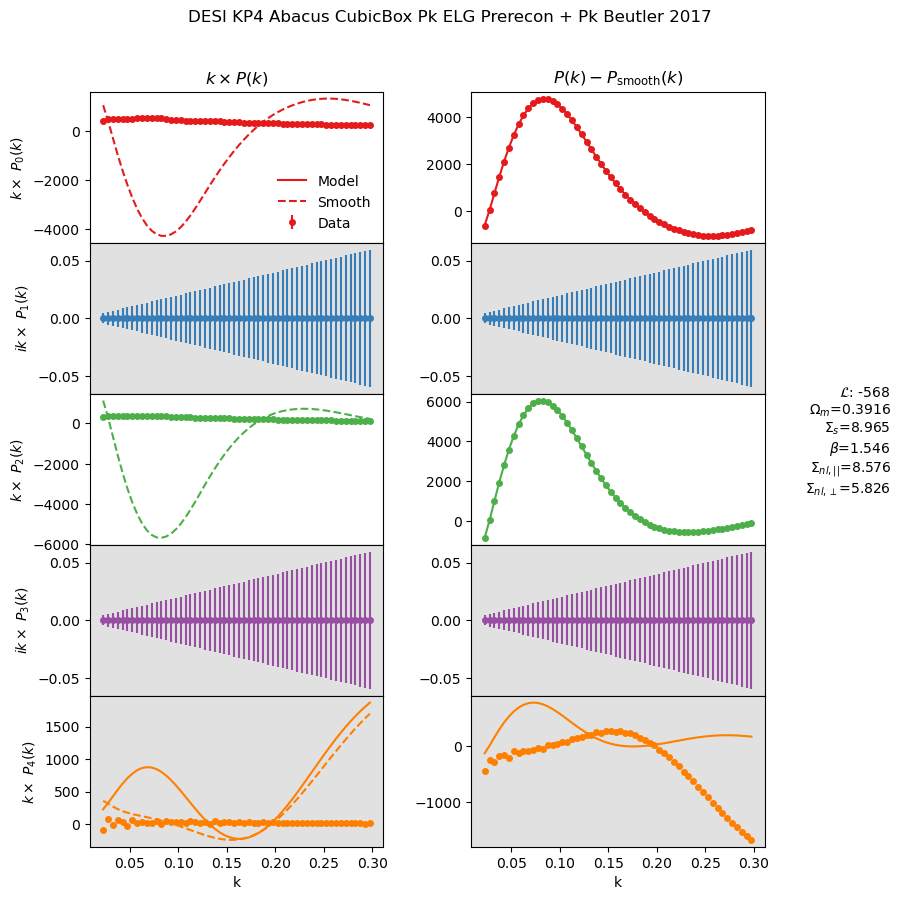

DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 0 2 0
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.53943870e+00  3.74193329e+05  9.15446628e+03 -8.30084785e+04
 -7.03896977e+04 -3.76238330e+04 -2.33565749e+04 -1.63223657e+04
 -1.16834013e+04 -9.48812118e+03 -7.58354472e+03  1.53152432e+05
  6.11266415e+03 -1.18368311e+05 -8.78801835e+04 -3.47799659e+04
 -7.61282716e+03  5.33391591e+03  1.01991392e+04  9.96125859e+03
  9.25018208e+03]
Chi squared/dof is 3042.5943925565516/86 at these values
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 1 2 1
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.77651878e+00  3.70588922e+05  7.60166849e+03 -1.01189126e+05
 -8.39821494e+04 -4.26568661e+04 -2.44114726e+04 -1.62638356e+04
 -1.16299480e+04 -9.65421097e+03 -7.69240017e+03  5.40521503e+04
  6.59964980e+03 -1.42478267e+05 -1.03235641e+05 -3.53930877e+04
 -1.67568664e+03  1.23154090e+04  1.58604495e+04  1.40303360e+04
  1.2163346

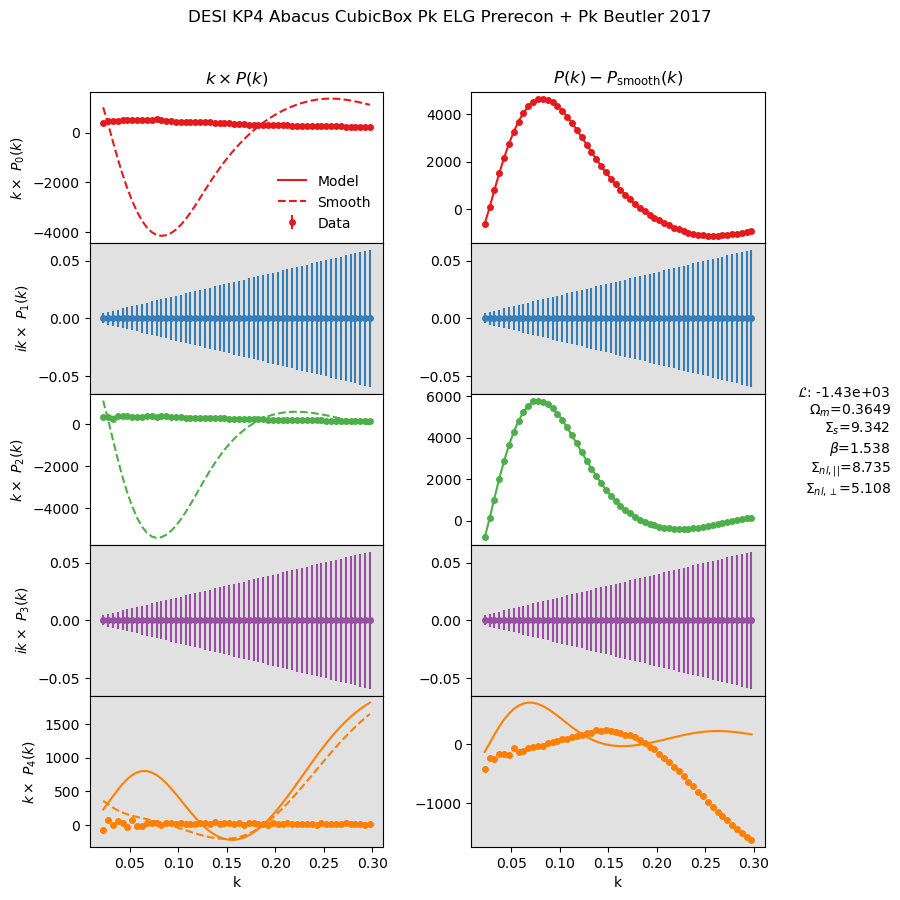

DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 11 2 11
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.90311054e+00  4.09846075e+05  6.71281035e+03 -1.01990057e+05
 -8.44730247e+04 -4.56987239e+04 -3.04796610e+04 -2.35874744e+04
 -1.86029900e+04 -1.50222714e+04 -1.13881140e+04  1.98155197e+05
  1.33807676e+03 -1.44494227e+05 -1.07384177e+05 -4.38285004e+04
 -1.23831753e+04  3.20329258e+03  1.00505042e+04  1.13508194e+04
  1.14856545e+04]
Chi squared/dof is 4365.816796743138/86 at these values
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 12 2 12
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.13845348e+00  3.28969276e+05  8.91200232e+03 -9.11458474e+04
 -7.54828060e+04 -3.86417877e+04 -2.29542667e+04 -1.57034277e+04
 -1.12716344e+04 -9.09237441e+03 -7.35643292e+03  2.23651664e+05
  5.17902748e+03 -1.28130546e+05 -8.89956648e+04 -2.94712488e+04
 -2.48492073e+03  8.46666879e+03  1.12079273e+04  1.06206596e+04
  9.7401

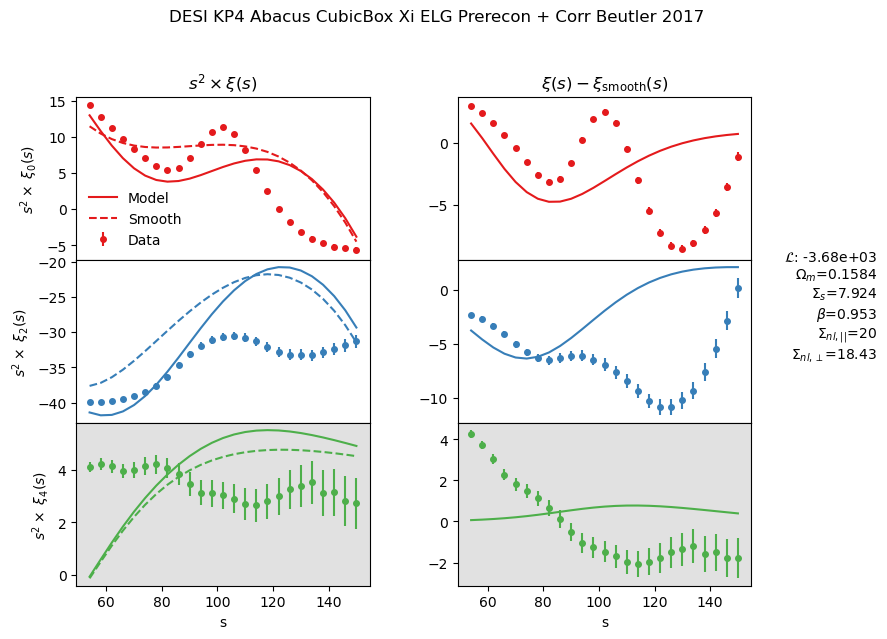

DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 0 0 0
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.55046993  0.00241793 -0.01036291  0.00140444 -0.00861715]
Chi squared/dof is 7632.089210012522/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 1 0 1
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.53168627  0.00252327 -0.01123166  0.00130552 -0.00859874]
Chi squared/dof is 8971.927508068513/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 2 0 2
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.49302817  0.0023111  -0.01043939  0.00232779 -0.01305644]
Chi squared/dof is 8854.342651560648/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 3 0 3
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.5443967   0.00258666 -0.01123572  0.00121426 -0.00847401]
Chi squared/dof is 7876.754593833112/40 at these values


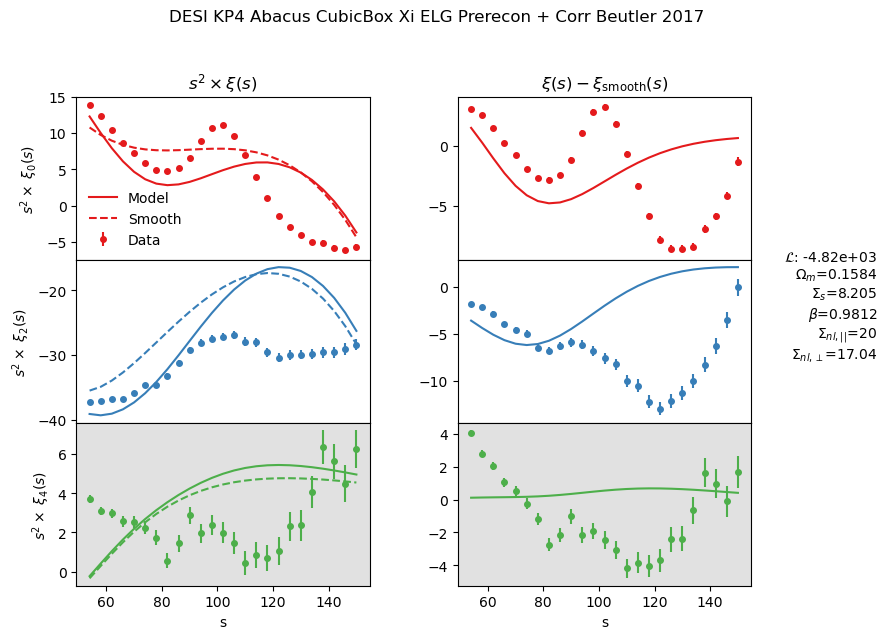

DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 11 0 11
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.47744083  0.00275651 -0.01196906  0.00202705 -0.01158241]
Chi squared/dof is 9789.99655961159/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 12 0 12
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.49444541  0.00220761 -0.00925565  0.0017542  -0.00983244]
Chi squared/dof is 8583.798054815645/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 13 0 13
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.55045169  0.00271829 -0.01141611  0.00124359 -0.00992796]
Chi squared/dof is 9096.831834556298/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Prerecon realisation 14 0 14
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.52402962  0.00197221 -0.00887921  0.00182796 -0.00884474]
Chi squared/dof is 9856.767313506254/40 at these 

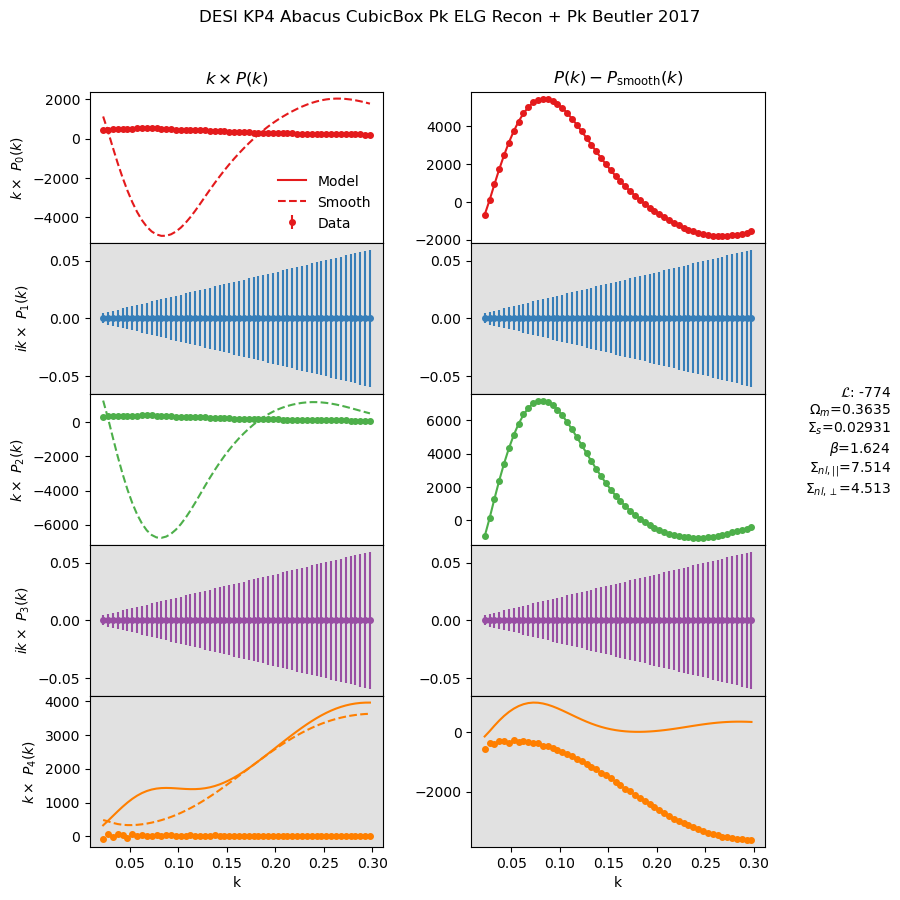

DESI KP4 Abacus CubicBox Pk ELG Recon realisation 0 3 0
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.23978162e+00  4.37353404e+05  2.72656038e+03 -9.48473989e+04
 -8.00987378e+04 -5.11634437e+04 -4.68500233e+04 -4.70169040e+04
 -4.46816536e+04 -4.18588165e+04 -3.72706887e+04  2.49010341e+05
 -5.50653056e+03 -1.40867195e+05 -1.10773167e+05 -7.04324315e+04
 -6.63612561e+04 -6.90095552e+04 -6.79065239e+04 -6.37381494e+04
 -5.52642339e+04]
Chi squared/dof is 3305.0313580568486/86 at these values
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 1 3 1
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.86990142e+00  4.17858864e+05  8.55060449e+02 -1.05545842e+05
 -8.83946578e+04 -5.67036284e+04 -5.27664629e+04 -5.42149914e+04
 -5.26299367e+04 -4.94805561e+04 -4.36141041e+04  1.03942796e+05
 -5.64458702e+03 -1.56650261e+05 -1.21066042e+05 -7.69608638e+04
 -7.47546623e+04 -8.01817581e+04 -8.05725539e+04 -7.55782392e+04
 -6.48323606e+04]

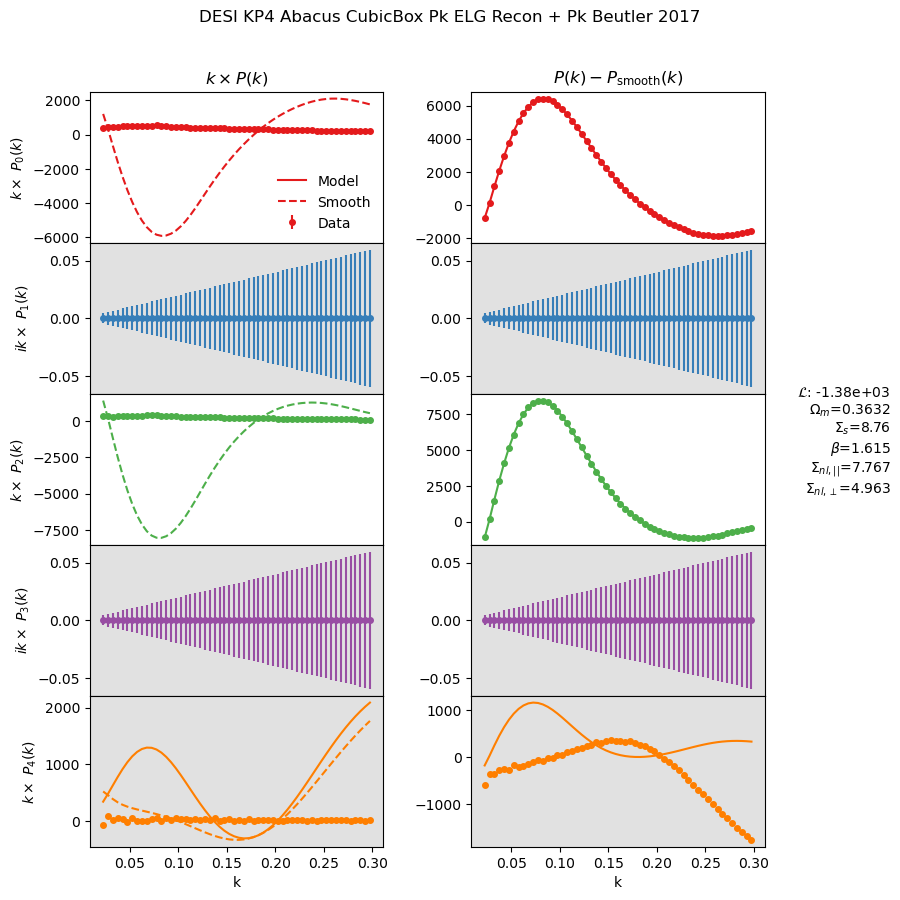

DESI KP4 Abacus CubicBox Pk ELG Recon realisation 11 3 11
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.01221148e+00  4.81491841e+05 -3.70702232e+02 -1.08246670e+05
 -9.00557497e+04 -5.75642507e+04 -5.38422981e+04 -5.55632078e+04
 -5.41438027e+04 -5.08971880e+04 -4.47181327e+04  3.15812216e+05
 -1.16433115e+04 -1.59580316e+05 -1.23483205e+05 -7.83266033e+04
 -7.62085621e+04 -8.17763874e+04 -8.21100484e+04 -7.68860047e+04
 -6.57523186e+04]
Chi squared/dof is 4063.3378516500325/86 at these values
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 12 3 12
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.63146165e+00  3.77566153e+05  6.95636606e+02 -1.18508656e+05
 -9.84640660e+04 -6.33600675e+04 -5.93367549e+04 -6.13906089e+04
 -5.98588216e+04 -5.61464186e+04 -4.93346303e+04  2.88200581e+05
 -1.03674210e+04 -1.73229394e+05 -1.31293754e+05 -8.33869399e+04
 -8.30797733e+04 -9.09906079e+04 -9.25985637e+04 -8.65593583e+04
 -7.35306376e

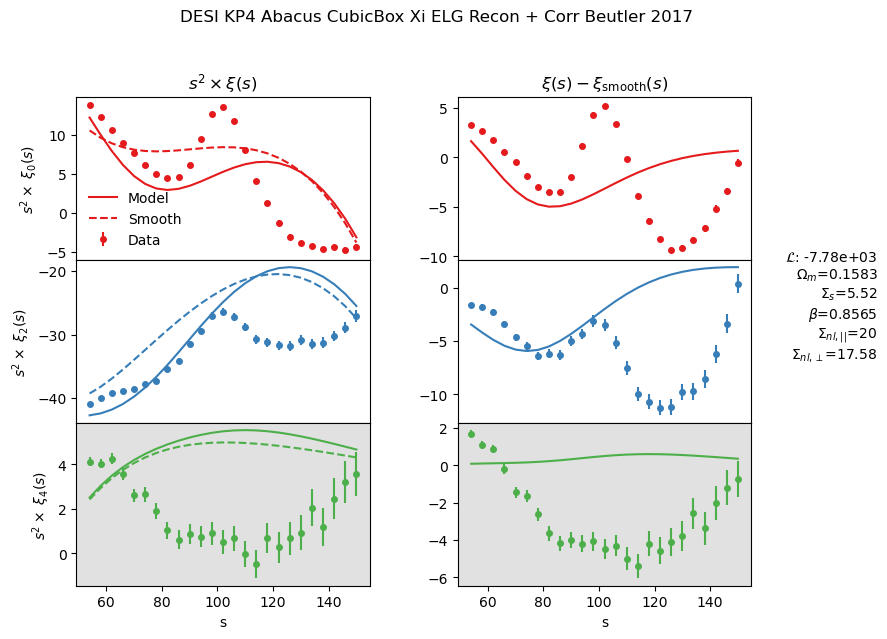

DESI KP4 Abacus CubicBox Xi ELG Recon realisation 15 1 15
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.54088586  0.00245237 -0.01067111  0.0016214  -0.00957505]
Chi squared/dof is 12208.02697258274/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Recon realisation 19 1 19
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.59205421  0.00247498 -0.01104815  0.00109811 -0.00768178]
Chi squared/dof is 13484.15033548678/40 at these values
DESI KP4 Abacus CubicBox Xi ELG Recon realisation 23 1 23
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.58675665  0.00259005 -0.01140815  0.00148009 -0.00932913]
Chi squared/dof is 12239.013313534098/40 at these values
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon mock mean 2 mean
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.88830921e+00  3.85310684e+05  8.61070525e+03 -8.91042397e+04
 -7.39000985e+04 -3.79566699e+04 -2.26099607e+04 -1.5

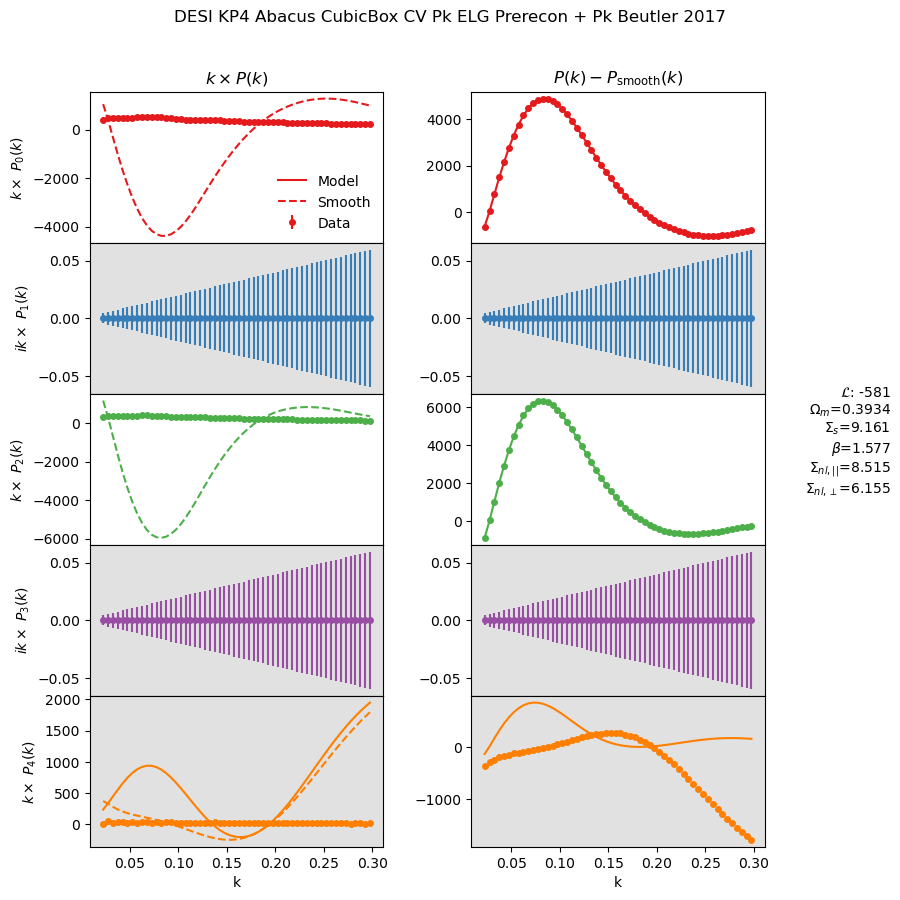

DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 0 2 0
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.97095335e+00  3.60884286e+05  9.60381850e+03 -8.78570898e+04
 -7.46049825e+04 -3.95634933e+04 -2.42955310e+04 -1.73080496e+04
 -1.29003958e+04 -1.05216623e+04 -8.23973756e+03  1.35534205e+05
  7.75338331e+03 -1.26529428e+05 -9.51275963e+04 -3.66863210e+04
 -6.68941921e+03  7.02973955e+03  1.18847588e+04  1.14842168e+04
  1.05471888e+04]
Chi squared/dof is 1683.3761401504653/86 at these values
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 1 2 1
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.67503798e+00  3.76017767e+05  7.95795394e+03 -1.01327541e+05
 -8.37440891e+04 -4.25975715e+04 -2.45636394e+04 -1.64860817e+04
 -1.17541854e+04 -9.64912548e+03 -7.66658530e+03  2.35461146e+05
  4.97775621e+03 -1.44261080e+05 -1.01864427e+05 -3.41691723e+04
 -2.08978674e+03  1.07737141e+04  1.39175817e+04  1.26021062e+04
  1.1

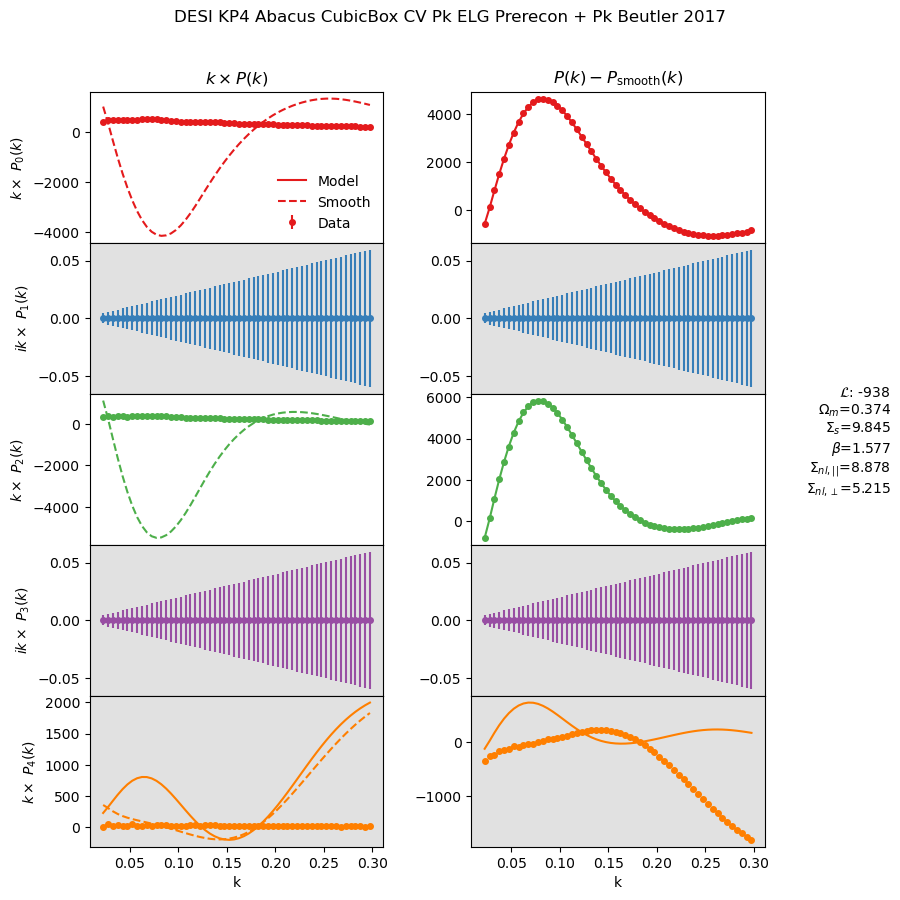

DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 11 2 11
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.11660948e+00  3.70542182e+05  9.00788870e+03 -9.02890337e+04
 -7.62183296e+04 -4.02150979e+04 -2.47295682e+04 -1.76817527e+04
 -1.32382011e+04 -1.07704524e+04 -8.46684332e+03  2.30473505e+05
  5.99135662e+03 -1.29921876e+05 -9.62697016e+04 -3.64789579e+04
 -6.41909483e+03  7.08423781e+03  1.17446860e+04  1.14760113e+04
  1.06711314e+04]
Chi squared/dof is 1733.58860480401/86 at these values
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 12 2 12
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.80080451e+00  3.59581777e+05  9.08422659e+03 -8.76089007e+04
 -7.20644433e+04 -3.68019839e+04 -2.19535200e+04 -1.52417149e+04
 -1.11475014e+04 -9.07617822e+03 -7.17304308e+03  1.81696205e+05
  6.30558961e+03 -1.25390944e+05 -8.77906523e+04 -2.99644412e+04
 -3.15313477e+03  7.99258004e+03  1.11134758e+04  1.05192514e+04
  9

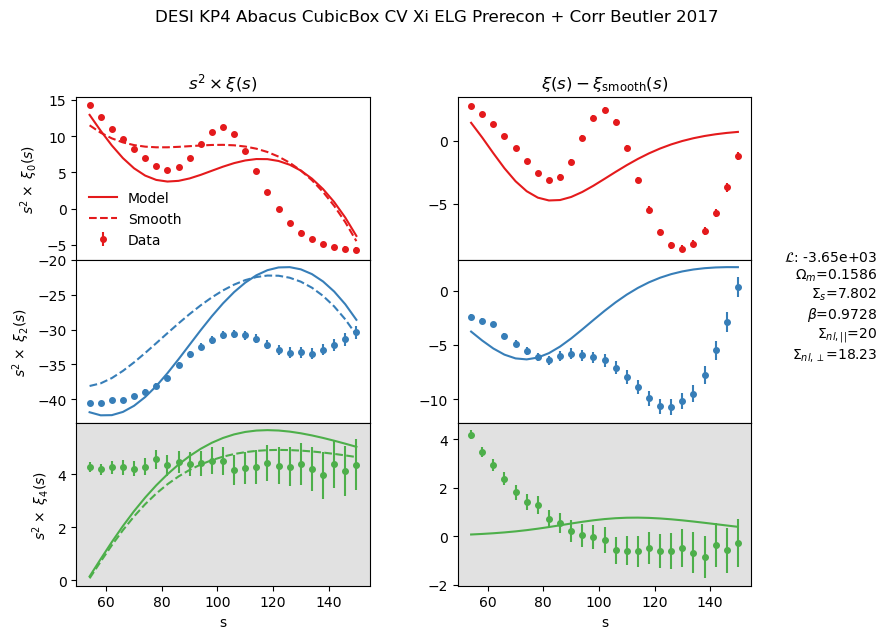

DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 0 0 0
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.53507944  0.00237827 -0.01044754  0.0010908  -0.00698333]
Chi squared/dof is 7260.332618073606/40 at these values
DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 1 0 1
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.52760624  0.00241478 -0.01049313  0.00138658 -0.00901429]
Chi squared/dof is 8122.606743556384/40 at these values
DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 2 0 2
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.51036811  0.00239858 -0.01054725  0.00203597 -0.01171871]
Chi squared/dof is 8725.767966653619/40 at these values
DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 3 0 3
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.54557107  0.00259151 -0.01157163  0.00109914 -0.00751256]
Chi squared/dof is 7304.116642370544/40 at t

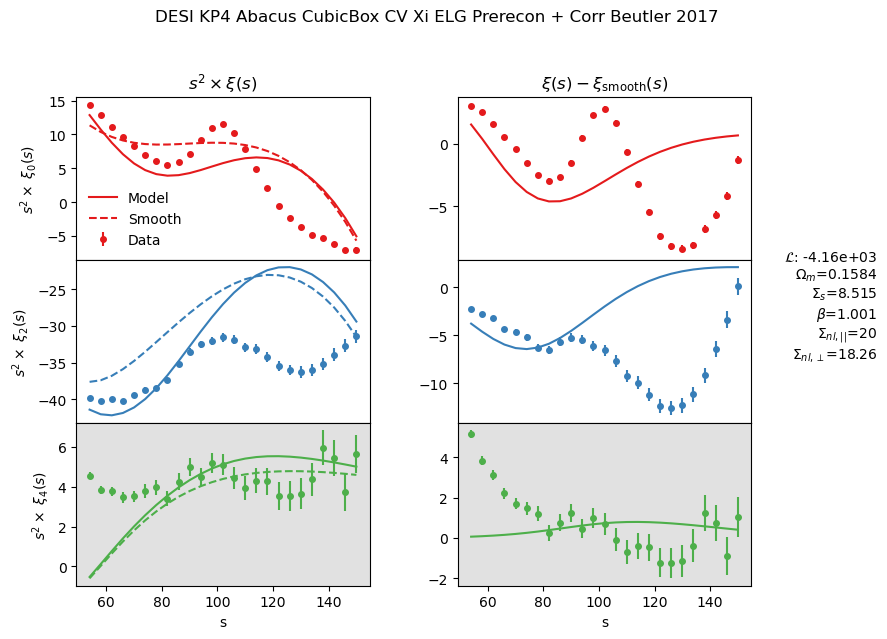

DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 11 0 11
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.60060084  0.00247499 -0.0107509   0.00116395 -0.00784128]
Chi squared/dof is 7883.452078027845/40 at these values
DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 12 0 12
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.5021009   0.00246344 -0.01071934  0.001461   -0.00904686]
Chi squared/dof is 7615.414740998674/40 at these values
DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 13 0 13
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.46657745  0.00243745 -0.01057038  0.00173394 -0.01038297]
Chi squared/dof is 7761.821966976504/40 at these values
DESI KP4 Abacus CubicBox CV Xi ELG Prerecon realisation 14 0 14
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 0.48481441  0.00224062 -0.00995503  0.00170422 -0.00949725]
Chi squared/dof is 9021.11546981349/

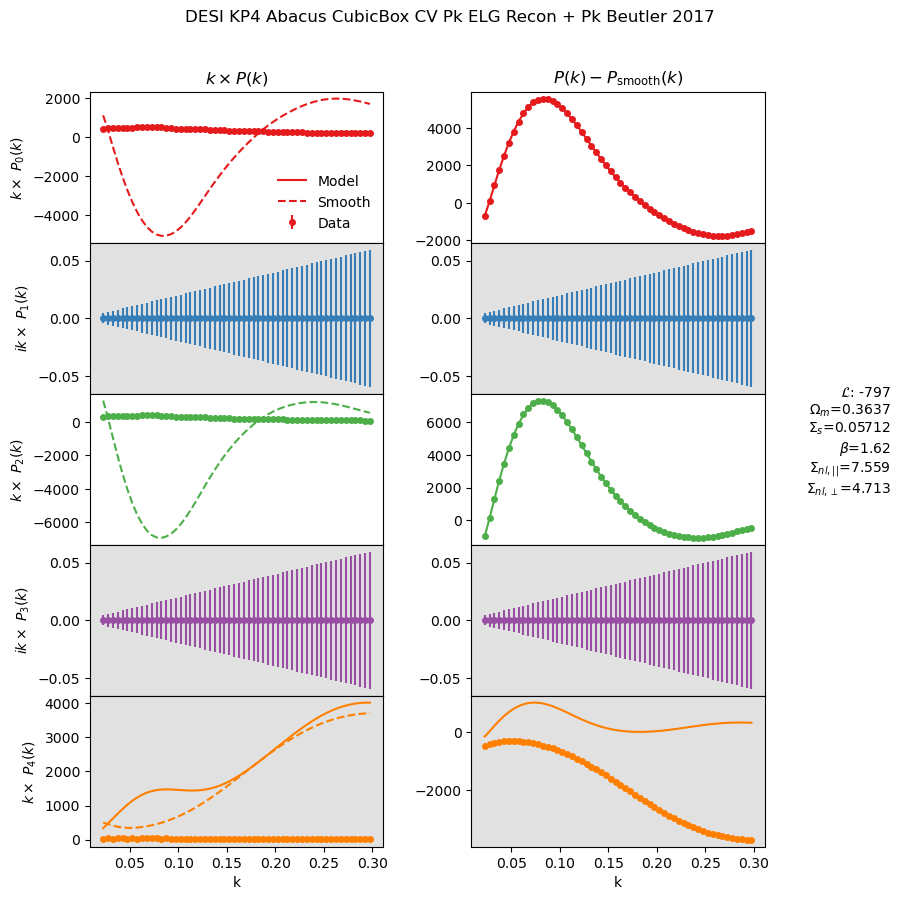

DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 0 3 0
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.72264245e+00  4.39378531e+05  1.83711727e+03 -1.02163763e+05
 -8.64858314e+04 -5.55125147e+04 -5.11911076e+04 -5.21390922e+04
 -5.03348871e+04 -4.73364664e+04 -4.20350848e+04  2.52927175e+05
 -5.91252370e+03 -1.51032853e+05 -1.19496044e+05 -7.61914995e+04
 -7.24376899e+04 -7.63500650e+04 -7.59697019e+04 -7.14051703e+04
 -6.18629413e+04]
Chi squared/dof is 2459.3762310636343/86 at these values
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 1 3 1
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.00483486e+00  4.56827081e+05  3.59779264e+02 -1.08187032e+05
 -9.04529028e+04 -5.79794194e+04 -5.38774439e+04 -5.52270820e+04
 -5.34728845e+04 -5.01948550e+04 -4.42985497e+04  3.43087000e+05
 -8.62302564e+03 -1.59894260e+05 -1.22479274e+05 -7.76698938e+04
 -7.59450950e+04 -8.19252393e+04 -8.26890809e+04 -7.75135509e+04
 -6.6316489

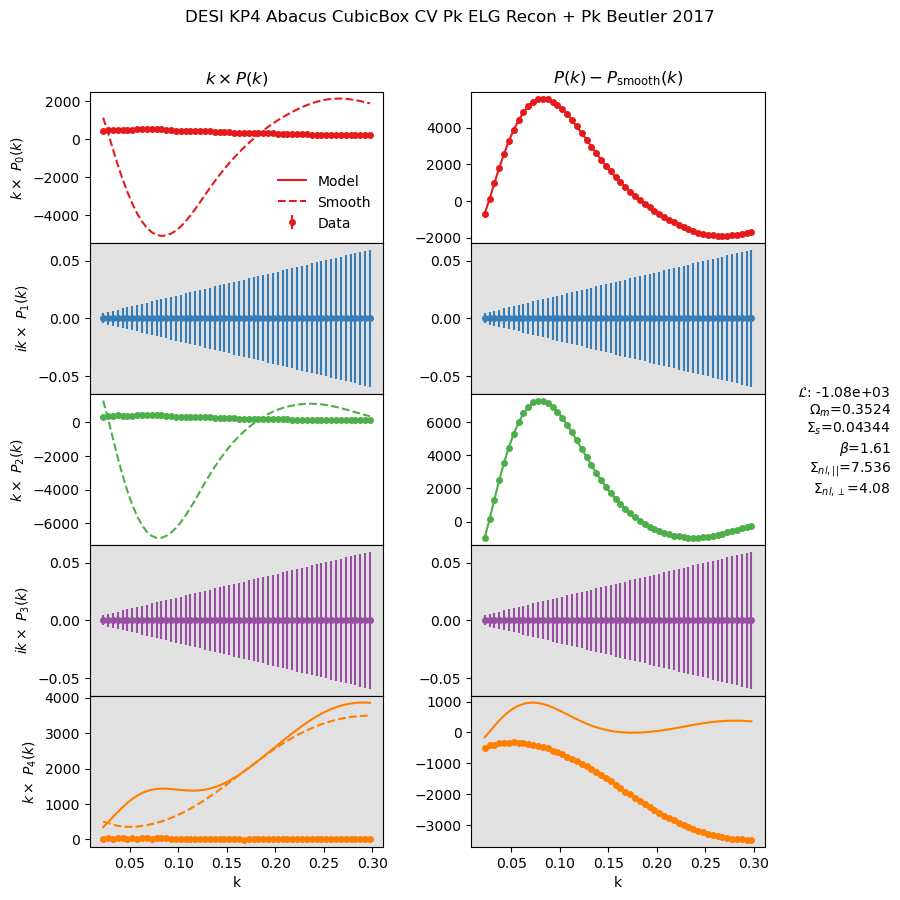

DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 11 3 11
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 5.74813385e+00  4.47292148e+05  1.44070148e+03 -1.03074799e+05
 -8.66052472e+04 -5.55627737e+04 -5.15391452e+04 -5.27208398e+04
 -5.09034632e+04 -4.77756951e+04 -4.22074761e+04  3.23794399e+05
 -7.01105850e+03 -1.52605102e+05 -1.17021963e+05 -7.42443978e+04
 -7.26060130e+04 -7.84417527e+04 -7.92724729e+04 -7.43963069e+04
 -6.34234084e+04]
Chi squared/dof is 2217.300153945046/86 at these values
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 12 3 12
Maximum likelihood nuisance parameters at maximum a posteriori point are [ 6.17476277e+00  4.40453821e+05  1.67913821e+03 -1.08404764e+05
 -9.13808595e+04 -5.90732068e+04 -5.52508826e+04 -5.73110016e+04
 -5.61278351e+04 -5.28546947e+04 -4.64761811e+04  3.12501897e+05
 -7.78890328e+03 -1.59457955e+05 -1.25208848e+05 -8.01929249e+04
 -7.80146577e+04 -8.39887813e+04 -8.45807745e+04 -7.93488322e+04
 -6.8096

In [11]:
logging.info("Creating plots")

fitname = []
datanames = ["CV_Xi_Prerecon", "CV_Xi_Recon", "CV_Pk_Prerecon", "CV_Pk_Recon"]#, "Pk_Recon"]
datanames = ["Xi_Prerecon", "Xi_Recon", "Pk_Prerecon", "Pk_Recon"]#, "Pk_Recon"]

c = [ChainConsumer(), ChainConsumer(), ChainConsumer(), ChainConsumer()]

# Loop over all the chains
stats = {k: [] for k in datanames}
output = {k: [] for k in datanames}
for posterior, weight, chain, evidence, model, data, extra in fitter.load():

    #print(chain)
    #print(extra)
    #print(extra['name'])
    #print(model.get_labels(), chain.shape)
    # Get the realisation number and redshift bin
    #print(extra['name']) 
    
    #continue 
    CVfile = ''
        
#     if CV:
#         CVfile = 'CV'
        
#     if not CV:
#         if "CV" in extra["name"]:
#            continue
#     else:
#         if "CV" not in extra['name']:
#             continue 
    
    
#     if "Pk" not in extra["name"]:
#        continue
            
#     #print(extra)
        
    recon_bin = 0 if "Prerecon" in extra["name"] else 1
    data_bin = 0 if "Xi" in extra["name"] else 1
    realisation = str(extra["name"].split()[-1]) if "realisation" in extra["name"] else "mean"
    chain_bin = int(2.0 * data_bin + recon_bin)
    print(extra["name"], chain_bin, realisation)
    #print(extra['name'])
    #print(model.get_labels(), chain.shape)
    # Store the chain in a dictionary with parameter names
    df = pd.DataFrame(chain, columns=model.get_labels())
    
    cols = df.columns.to_numpy()
    #df = df.rename(columns={r'$\beta_{\\phi(N_{\mathrm{eff}})}$' : r'$\beta_{\phi(N_{\mathrm{eff}})}$'})

    # Compute alpha_par and alpha_perp for each point in the chain
    if not neff_free_only and not omega_matter_free_only:
        alpha_par, alpha_perp = model.get_alphas(df["$\\alpha$"].to_numpy(), df["$\\epsilon$"].to_numpy())
        df["$\\alpha_\\parallel$"] = alpha_par
        df["$\\alpha_\\perp$"] = alpha_perp
                                                        
    # Get the MAP (maximum a posteriori) point and set the model up at this point
    #model.broadband_type = "poly" 
    #model.n_poly = (0,2)
    #model.delta = None 
    
    model.set_data(data)
    
    r_s = model.camb.get_data()["r_s"]
    max_post = posterior.argmax()
    params = df.loc[max_post]
    params_dict = model.get_param_dict(chain[max_post])
    #print(params_dict)
    for name, val in params_dict.items():
        model.set_default(name, val)

    # Get some useful properties of the fit, and plot the MAP model against the data if it's the mock mean or realisation 10 (chosen randomly!)
    display = True if realisation == "mean" or realisation == "10" else False
    #print(params_dict)
    new_chi_squared, dof, bband, mods, smooths = model.plot(params_dict, display=display)

    # Add the chain or MAP to the Chainconsumer plots
    extra.pop("realisation", None)
    if realisation == "mean":
        #print(realisation)
        c[chain_bin].add_chain(df, weights=weight, **extra, plot_contour=True, plot_point=False, show_as_1d_prior=False)
        #print(df)
    #else:
    #    c[chain_bin].add_marker(params, **extra, marker_size=80)

    # Compute some summary statistics and add them to a dictionary
    
    params = [
                "$\\alpha_\\parallel$",
                "$\\alpha_\\perp$",
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
                "$\\Sigma_s$"
            ]
    
    if neff_free_only:
        
        params = [
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
                "$\\Sigma_s$",
                "$N_{\\mathrm{eff}}$"
            ]
        
    if omega_matter_free_only:
        
        params = [
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
                "$\\Sigma_s$",
                "$\\Omega_m$"
            ]
    
    if '$\\Sigma_s$' not in cols:
        params = [
                "$\\alpha_\\parallel$",
                "$\\alpha_\\perp$",
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
            ]
    
    if omega_matter_free: 
        params.append("$\\Omega_m$")
        
    if neff_free:
        params.append("$N_{\\mathrm{eff}}$")
        
    if phase_shift_free: 
        params.append("$\\beta_{\\phi(N_{\\mathrm{eff}})}$")
    
    mean, cov = weighted_avg_and_cov(
        df[
            params
        ],
        weight,
        axis=0,
    )
    
    # print(params)
    #print(weighted_avg_and_cov(df["$\\beta$"], weight, axis=0)[0])
#     print(weighted_avg_and_cov(df["$\\alpha$"], weight, axis=0)[0])
#     print(weighted_avg_and_cov(df["$\\epsilon$"], weight, axis=0)[0])

#     if 'Prerecon' not in extra['name']:
#         #sigma_s_mean += weighted_avg_and_cov(df["$\\Sigma_s$"], weight, axis=0)[0]
#         count += 1
        
#         beta_mean += weighted_avg_and_cov(df["$\\beta$"], weight, axis=0)[0]
    
#     print(mean)
    #continue
    
    if neff_free_only or omega_matter_free_only:
        continue 
        
    if omega_matter_free: ###################################
        
        corr_alpha_para_perp = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
        corr_alpha_para_phase = cov[5, 0] / np.sqrt(cov[5, 5] * cov[0, 0])
        corr_alpha_perp_phase = cov[5, 1] / np.sqrt(cov[5, 5] * cov[1, 1])
        
        if '$\\Sigma_s$' not in cols:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
                # mean omegam, stdev omegam, corrs omegam and alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
                corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3]]#, mean[4]]
            )
            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        
        else:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
                # mean omegam, stdev omegam, corrs omegam and alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp, mean sigma_s 
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
                corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3], mean[4]]
            )

            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        
    elif neff_free: ###################################
        
        corr_alpha_para_perp = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
        corr_alpha_para_phase = cov[5, 0] / np.sqrt(cov[5, 5] * cov[0, 0])
        corr_alpha_perp_phase = cov[5, 1] / np.sqrt(cov[5, 5] * cov[1, 1])
        
        if '$\\Sigma_s$' not in cols:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
                # mean neff, stdev neff, corrs neff and alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp 
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
                corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3]]#, mean[4]]
            )
            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        else:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
                # mean neff, stdev neff, corrs neff and alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp, mean sigma_s 
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
                corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3], mean[4]]
            )
        
        #print(len(stats[datanames[chain_bin]][-1]))

            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev neff, corrs neff/alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        
    elif phase_shift_free: ################################### 
        
        corr_alpha_para_perp = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
        corr_alpha_para_phase = cov[5, 0] / np.sqrt(cov[5, 5] * cov[0, 0])
        corr_alpha_perp_phase = cov[5, 1] / np.sqrt(cov[5, 5] * cov[1, 1])
        
        if '$\\Sigma_s$' not in cols:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
                # mean beta, stdev beta, corrs beta and alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp, mean sigma_s 
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
                corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3]]#, mean[4]]
            )
            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev omegam, corrs omegam/alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        else:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
                # mean beta, stdev beta, corrs beta and alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp, mean sigma_s 
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), 
                corr_alpha_para_perp, mean[5], np.sqrt(cov[5,5]), corr_alpha_para_phase, corr_alpha_perp_phase, new_chi_squared, mean[2], mean[3], mean[4]]
            )

            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas , corrs alphas, stdev beta, corrs beta/alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {mean[5]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr_alpha_para_perp:7.3f}, {np.sqrt(cov[5, 5]):6.4f}, {corr_alpha_para_phase:7.3f}, {corr_alpha_perp_phase:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        
        
    else: ###################################
        
        corr = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
        
        if '$\\Sigma_s$' not in cols:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, chisquare, 
            # mean sigma_\\, mean sigma_perp
            [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), corr, new_chi_squared, mean[2], mean[3]]#, mean[4]]
            )
            
            output[datanames[chain_bin]].append(
            # realisation name, all means of params, stdevs on alphas .... other stats 
            f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        else:
            stats[datanames[chain_bin]].append( # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, chisquare, 
                # mean sigma_\\, mean sigma_perp, mean sigma_s 
                [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), corr, new_chi_squared, mean[2], mean[3], mean[4]]
            )

            output[datanames[chain_bin]].append(
                # realisation name, all means of params, stdevs on alphas .... other stats 
                f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {mean[4]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
            )
        #print('test')
        
# print(beta_mean/count)

Plot the contour plots and output the summary statistics

Xi_Prerecon


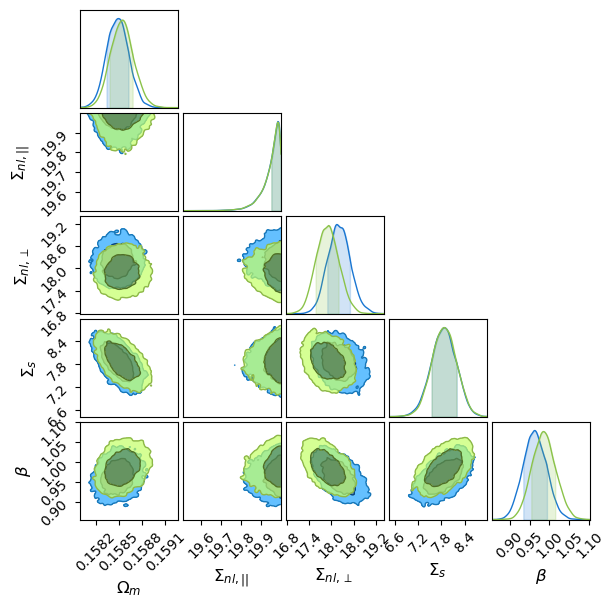

Xi_Recon


/global/homes/a/abbew25/.conda/envs/barry_env_desiproject_aw/lib/python3.11/site-packages/chainconsumer/chainconsumer.py:796: RuntimeWarning: divide by zero encountered in scalar divide
  shade_alpha = 1.0 / np.sqrt(num_chains)


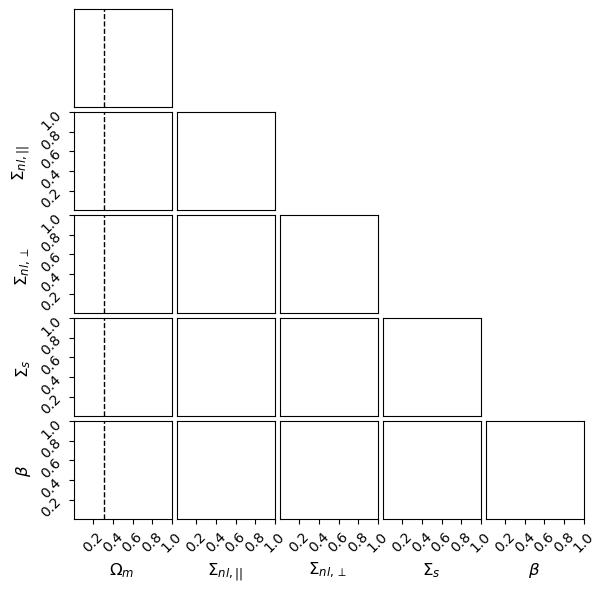

Pk_Prerecon


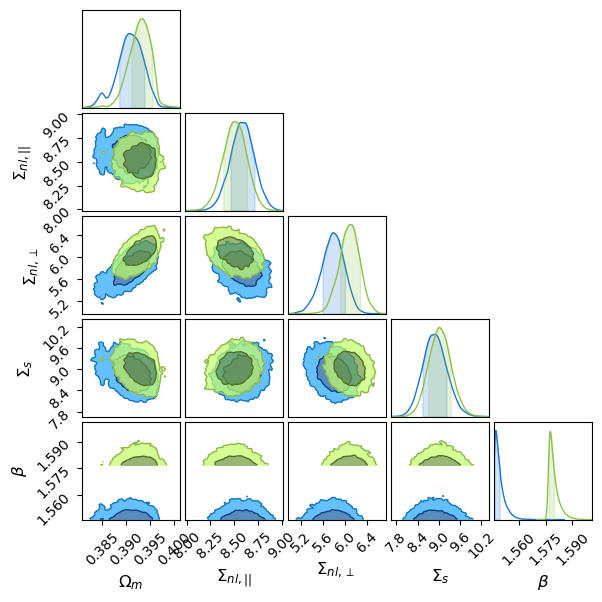

Pk_Recon


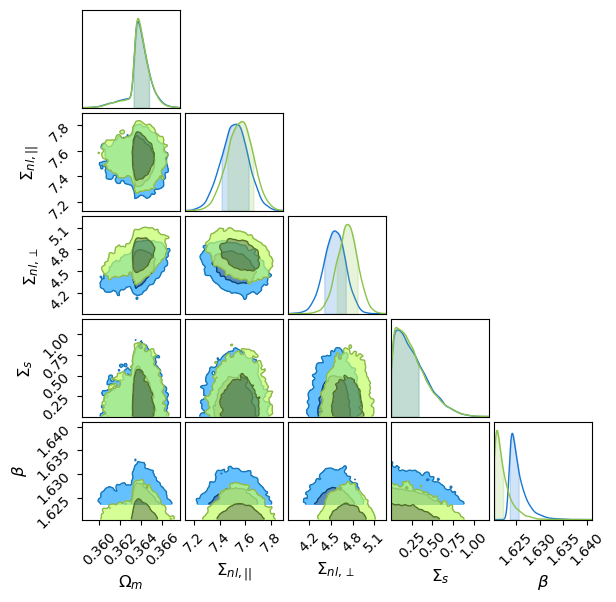

In [12]:
def plot_errors(stats, omega_matter_free=False, neff_free=False, phase_shift_free=False, suffix=''):
    
    nstats = len(stats)
    means = np.mean(stats, axis=0)
    covs = np.cov(stats, rowvar=False)
    corr = covs[0, 1] / np.sqrt(covs[0, 0] * covs[1, 1])

    labels = [r"$\sigma_{\alpha,||}$", r"$\sigma_{\alpha,\perp}$", r"$\rho(\alpha_{||},\alpha_{\perp})$"] 
    colors = ["r", "b", "g"]
    
    #print(np.array(stats).T.shape)
    
    if omega_matter_free:
        labels.append(r"$\sigma_{\Omega_m}$")
        labels.append(r"$\rho(\alpha_{||},\Omega_m)$")
        labels.append(r"$\rho(\alpha_{\perp},\Omega_m)$")
        colors.append("orange")
        colors.append("grey")
        colors.append("yellow")
        
    if neff_free:
        labels.append(r"$\sigma_{N_{\mathrm{eff}}}$")
        labels.append(r"$\rho(\alpha_{||},N_{\mathrm{eff}})$")
        labels.append(r"$\rho(\alpha_{\perp},N_{\mathrm{eff}})$")
        colors.append("orange")
        colors.append("grey")
        colors.append("yellow")
        
    if phase_shift_free: 
        labels.append(r"$\sigma_{\beta}$")
        labels.append(r"$\rho(\alpha_{||},\beta)$")
        labels.append(r"$\rho(\alpha_{\perp},\beta)$")
        colors.append("orange")
        colors.append("grey")
        colors.append("yellow")

    fig, axes = plt.subplots(figsize=(7, 2), nrows=1, ncols=len(labels), sharey=True, squeeze=False)
    if omega_matter_free or neff_free or phase_shift_free:
        plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05, right=2.0, hspace=0.3)
    else:
        plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05, right=0.95, hspace=0.3)
    
    range_vals = [2,3,4]
    range_means = [2,3,4]
    stds_arr = [np.sqrt(covs[0, 0]), np.sqrt(covs[1, 1]), corr]
    
    if omega_matter_free or neff_free or phase_shift_free: 
        range_vals = [2,3,4,6,7,8] 
        stds_arr = [
                   np.sqrt(covs[0, 0]), 
                   np.sqrt(covs[1, 1]), 
                   corr,
                   np.sqrt(covs[5, 5]),
                   covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5]),
                   covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])
                   ]
        range_means = [2,3,4,6,7,8] 
    
    for ax, vals, avgs, stds, l, c in zip(axes.T, np.array(stats).T[range_vals,:], means[range_means], stds_arr, labels, colors):

        ax[0].hist(vals, 10, color=c, histtype="stepfilled", alpha=0.2, density=False, zorder=0)
        ax[0].hist(vals, 10, color=c, histtype="step", alpha=1.0, lw=1.3, density=False, zorder=1)
        ax[0].axvline(avgs, color="k", ls="--", zorder=2)
        ax[0].axvline(stds, color="k", ls=":", zorder=2)
        ax[0].set_xlabel(l)
        
    axes[0, 0].set_ylabel(r"$N_{\mathrm{mocks}}$")

    #plt.savefig("plots/desi_kp4_abacus_cubic_ELG"+suffix+"/output/histplot_v2.png", bbox_inches='tight')
    plt.show()

    return nstats, means, covs, corr

truth = {"$\\alpha$": 1.0, "$\\epsilon$": 0, "$\\alpha_\\perp$": 1.0, "$\\alpha_\\parallel$": 1.0}
#truth={"$\\epsilon$": 0,}
# truth = {"$\\alpha_\\perp$": 1.0, "$\\alpha_\\parallel$": 1.0}

if neff_free_only:
    truth = {}
    truth["$N_{\mathrm{eff}}$"] = 3.044
    
if omega_matter_free_only:
    truth = {}
    truth["$\\Omega_m$"] = 0.31  

if omega_matter_free: 
    truth["$\\Omega_m$"] = 0.31
if neff_free:
    truth["$N_{\mathrm{eff}}$"] = 3.044
if phase_shift_free:
    truth["$\\beta_{\\phi(N_{\\mathrm{eff}})}$"] = 1.0

parameters = [names for names in truth]
parameters.append("$\\Sigma_{nl,||}$")
parameters.append("$\\Sigma_{nl,\\perp}$")
parameters.append("$\\Sigma_s$")
parameters.append('$\\beta$')

suffix = ''

if omega_matter_free: 
    suffix = '_omfree'
elif neff_free:
    suffix = '_nefffree'
elif phase_shift_free:
    suffix = '_phaseshiftfree'

for chain_bin in range(len(c)):
    
    # for i in stats[datanames[chain_bin]]:
    #     print(len(i))
    # #if datanames[chain_bin] != 'CV_Pk_Recon':
    #    continue 
        
#     if 'Pk' not in datanames[chain_bin]:
#         continue 
    
        
    print(datanames[chain_bin])
    
    #print(dir(c[chain_bin]))
    #print(stats[datanames[chain_bin]])
    
    parameters_used = parameters 
    
    if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]:
        parameters_used = parameters[0:-1]
        
    if not neff_free_only and not omega_matter_free_only:

        c[chain_bin].plotter.plot(
        truth=truth,
            parameters=(parameters_used[:2]+parameters_used[4:]),
            #parameters =parameters[2:],
            legend=False,
            display=True,
            figsize=(6,6), 
            #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",

        )
        
    else:
        
        c[chain_bin].plotter.plot(
        truth=truth,
            parameters=parameters,
            #parameters =parameters[2:],
            legend=False,
            display=True,
            figsize=(6,6), 
            #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",

        )
        
        continue 
    
    if omega_matter_free or neff_free or phase_shift_free: 
        c[chain_bin].plotter.plot(
        truth=truth,
            parameters=(parameters_used[:2]+[parameters_used[4]]),
            #parameters =parameters[2:],
            legend=False,
            display=True,
            figsize=(6,6), 
            #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",

        )
    else:
        c[chain_bin].plotter.plot(
        truth=truth,
            parameters=(parameters_used[:2]),
            #parameters =parameters[2:],
            legend=False,
            display=True,
            figsize=(6,6), 
            #filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2" + CVfile + ".png",

        )
    
    # Plot histograms of the errors and r_off
    nstats, means, covs, corr = plot_errors(stats[datanames[chain_bin]],
                                            omega_matter_free=omega_matter_free,
                                            neff_free=neff_free,
                                            phase_shift_free=phase_shift_free,
                                            suffix=suffix)
    
    #continue 
    #continue 
    # Save all the numbers to a file
    if omega_matter_free:###################################
        
        with open("plots/desi_kp4_abacus_cubic_ELG_omfree/output/Barry_fit_" + CVfile + datanames[chain_bin] + ".txt", "w") as f:
            
            if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]:
                f.write(
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Omegam, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Omegam, corr_Omegam_alpha_par, corr_Omegam_alpha_prep, rd_of_template, bf_chi2, dof\n"
                    )
                
            else:
                f.write(
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, Omegam, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Omegam, corr_Omegam_alpha_par, corr_Omegam_alpha_prep, rd_of_template, bf_chi2, dof\n"
                    ) 

            for l in output[datanames[chain_bin]]:
                f.write(l + "\n")

            # And now the average of all the individual realisations
            f.write("# ---------------------------------------------------\n")
            f.write(
                "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <omega_m>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_omega_m>, <corr_alpha_par_perp>, <corr_alpha_par_m>, <corr_alpha_perp_m>, std_alpha_par, std_alpha_perp, std_omegam, corr_alpha_par_perp, corr_alpha_par_omegam, corr_alpha_perp_omegam, <bf_chi2>\n"
                )
            f.write(
                f"{means[0]:6.4f}, {means[1]:6.4f}, {means[10]:6.4f}, {means[11]:6.4f}, {means[5]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[6]:6.4f}, {means[4]:6.4f}, {means[7]:6.4f}, {means[8]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[5, 5]):6.4f}, {corr:6.4f}, {(covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5])):6.4f},{(covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])):6.4f}, {means[9]:7.3f}\n"
                )
            
            
    elif neff_free:###################################
        
        # print('check')
        with open("plots/desi_kp4_abacus_cubic_ELG_nefffree/output/Barry_fit_" + CVfile + datanames[chain_bin] + ".txt", "w") as f:
            
            if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]: 
                f.write(
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Neff, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Neff, corr_Neff_alpha_par, corr_Neff_alpha_prep, rd_of_template, bf_chi2, dof\n"
                    )
            
            else: 
                f.write(
                "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, Neff, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_Neff, corr_Neff_alpha_par, corr_Neff_alpha_prep, rd_of_template, bf_chi2, dof\n"
                )
            
            for l in output[datanames[chain_bin]]:
                f.write(l + "\n")

            # And now the average of all the individual realisations
            f.write("# ---------------------------------------------------\n")
            f.write(
                "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <neff>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_neff>, <corr_alpha_par_perp>, <corr_alpha_par_neff>, <corr_alpha_perp_neff>, std_alpha_par, std_alpha_perp, std_neff, corr_alpha_par_perp, corr_alpha_par_neff, corr_alpha_perp_neff, <bf_chi2>\n"
                )
            f.write(
                f"{means[0]:6.4f}, {means[1]:6.4f}, {means[10]:6.4f}, {means[11]:6.4f}, {means[5]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[6]:6.4f}, {means[4]:6.4f}, {means[7]:6.4f}, {means[8]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[5, 5]):6.4f}, {corr:6.4f}, {(covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5])):6.4f},{(covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])):6.4f}, {means[9]:7.3f}\n"
                )
            
    elif phase_shift_free: ###################################
        
        #print(datanames[chain_bin])
        # mean alpha_\\, mean alpha_para, stdev alpha\\, stdev alphaperp, corr_alphas, 
            # mean beta, stdev beta, corrs beta and alphas, chisquare, 
            # mean sigma_\\, mean sigma_perp, mean sigma_s 
        filepath = "plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree/output/Barry_fit_"
        if wallisch18:
            filepath = "plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-wallisch18/output/Barry_fit_"
        if eh1998:
            filepath = "plots/desi_kp4_abacus_cubic_ELG_phaseshiftfree-eh1998/output/Barry_fit_"
            
        
        with open(filepath + CVfile + datanames[chain_bin] + ".txt", "w") as f:
            
            if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]: 
                f.write(
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, beta, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_beta, corr_beta_alpha_par, corr_beta_alpha_prep, rd_of_template, bf_chi2, dof\n"
                    )
            else: 
                f.write(
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, beta, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, sigma_beta, corr_beta_alpha_par, corr_beta_alpha_prep, rd_of_template, bf_chi2, dof\n"
                    )
                
            for l in output[datanames[chain_bin]]:
                f.write(l + "\n")

            # And now the average of all the individual realisations
            f.write("# ---------------------------------------------------\n")
            f.write(
                "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <phi>, <sigma_alpha_par>, <sigma_alpha_perp>, <sigma_phi>, <corr_alpha_par_perp>, <corr_alpha_par_phi>, <corr_alpha_perp_phi>, std_alpha_par, std_alpha_perp, std_phi, corr_alpha_par_perp, corr_alpha_par_phi, corr_alpha_perp_phi, <bf_chi2>\n"
                )
            f.write(
                f"{means[0]:6.4f}, {means[1]:6.4f}, {means[10]:6.4f}, {means[11]:6.4f}, {means[5]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[6]:6.4f}, {means[4]:6.4f}, {means[7]:6.4f}, {means[8]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[5, 5]):6.4f}, {corr:6.4f}, {(covs[0, 5] / np.sqrt(covs[0, 0] * covs[5, 5])):6.4f},{(covs[5, 1] / np.sqrt(covs[5, 5] * covs[1, 1])):6.4f}, {means[9]:7.3f}\n"
                )
        
    else:###################################
            
        with open("plots/desi_kp4_abacus_cubic_ELG/output/Barry_fit_" + CVfile + datanames[chain_bin] + ".txt", "w") as f:
            
            if nosigma_s_incorr and 'Pk' not in datanames[chain_bin]:
                f.write(# realisation name, all means of params, stdevs on alphas .... other stats 
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, Sigma_s, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, rd_of_template, bf_chi2, dof\n"
                    )
            else:
                f.write(# realisation name, all means of params, stdevs on alphas .... other stats 
                    "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, rd_of_template, bf_chi2, dof\n"
                    )
            for l in output[datanames[chain_bin]]:
                f.write(l + "\n")

            # And now the average of all the individual realisations
            f.write("# ---------------------------------------------------\n")
            f.write(
                "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <sigma_alpha_par>, <sigma_alpha_perp>, <corr_alpha_par_perp>, std_alpha_par, std_alpha_perp, corr_alpha_par_perp, <bf_chi2>\n"
                )
            f.write(
                f"{means[0]:6.4f}, {means[1]:6.4f}, {means[6]:6.4f}, {means[7]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[4]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {corr:6.4f}, {means[5]:7.3f}\n"
                )
        